# Importación


In [205]:
import pandas as pd
import numpy as np 
import plotly as ply
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import scipy.stats as stats



In [206]:
df_RatedFlights = pd.read_csv('rated_flights.csv')

df_RatedFlights

,Date,Airline,Departure,Arrival,OverallRating,ReportLink
0,19/01/2025,LATAM Brasil,NATNatal Greater Natal International Airport,GRUSao Paulo Guarulhos Int'l,7,../flightlog/report_625375_LATAM Brasil_3443.htm
1,13/01/2025,KLM,BCNBarcelona El Prat,AMSAmsterdam Schiphol,8,../flightlog/report_624841_KLM_1518.htm
2,11/01/2025,Azul Linhas Aereas,SSASalvador Deputado Luís Eduardo Magalhães In...,RECRecife Guararapes - Gilberto Freyre Int'l,10,../flightlog/report_625374_Azul Linhas Aereas_...
3,09/01/2025,Garuda,SINSingapore Changi,CGKJakarta Soekarno - Hatta,9,../flightlog/report_624575_Garuda_839.htm
4,08/01/2025,Azul Linhas Aereas,GRUSao Paulo Guarulhos Int'l,IOSIlheus,10,../flightlog/report_625373_Azul Linhas Aereas_...
...,...,...,...,...,...,...
3095,25/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,AMSAmsterdam Schiphol,7,../flightlog/report_221289_DutchBird_902.htm
3096,12/05/2003,DutchBird,AMSAmsterdam Schiphol,LPALas Palmas De Gran Canaria Gando,6,../flightlog/report_221286_DutchBird_901.htm
3097,12/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,FORFortaleza Pinto Martins,7,../flightlog/report_221287_DutchBird_901.htm
3098,07/02/2003,IrAero,CGKJakarta Soekarno - Hatta,SUBSurabaya Juanda,7,../flightlog/report_339682_IrAero_200.htm


Los datos presentados corresponden a algunos de los vuelos sucitados entre los años 2002-2024, en el cual se destaca como variable categórica el overall rating el cual ponderiza el rating que las personas le dieron a su experiencia en el check-in, waiting and boarding, in flight y arrival 

Los únicos datos con un componente "subjetivo" son el overall rating y los remarks dentro del reportLink, ya que reflejan la percepción individual de cada experiencia.

# Limpieza

Los datos ingresados manualmente se validan antes de incluirse en el reporte, verificando aerolíneas y ciudades según sus códigos. Además, el formato se asegura automáticamente mediante un formulario con validación en tiempo real

In [207]:
nans= df_RatedFlights.isnull().sum()
print(nans)

#no missing values in the dataset

Date             0
Airline          0
Departure        0
Arrival          0
OverallRating    0
ReportLink       0
dtype: int64


In [208]:
duplicates= df_RatedFlights.duplicated()

print(duplicates.sum())

#no duplicates in the dataset

0


# Exploración y visualización 

## Análisis de vuelos en el Dataframe: **df_RatedFlights**

### Existencia de vuelos que partan de una ciudad y regresen a la misma

In [209]:
sameDepArrFlights= df_RatedFlights['Departure'] == df_RatedFlights['Arrival']
print("vuelos de origen y destino igual:",sameDepArrFlights.sum())

vuelos de origen y destino igual: 9


In [210]:
df_RatedFlights[sameDepArrFlights]

,Date,Airline,Departure,Arrival,OverallRating,ReportLink
688,25/05/2022,Sundair,DRSDresden Klotzsche Airport,DRSDresden Klotzsche Airport,10,../flightlog/report_545086_Sundair_1960.htm
701,18/04/2022,Sundair,LEJLeipzig,LEJLeipzig,8,../flightlog/report_542960_Sundair_8796.htm
756,05/02/2022,Air New Zealand,AKLAuckland Auckland International Airport,AKLAuckland Auckland International Airport,10,../flightlog/report_537770_Air New Zealand_601...
760,19/01/2022,Air New Zealand,VCVVictorville George AFB - USA California,VCVVictorville George AFB - USA California,10,../flightlog/report_536960_Air New Zealand_600...
821,16/10/2021,Danish Air Transport,CPHCopenhagen Kastrup,CPHCopenhagen Kastrup,10,../flightlog/report_530715_Danish Air Transpor...
970,07/11/2020,Eurowings,TXLBerlin Tegel,TXLBerlin Tegel,8,../flightlog/report_508926_Eurowings_5237.htm
1735,04/03/2017,Delta Air Lines,ATLAtlanta Hartsfield Jackson International - ...,ATLAtlanta Hartsfield Jackson International - ...,9,../flightlog/report_389510_Delta Air Lines_31.htm
2264,11/11/2014,KLM,AMSAmsterdam Schiphol,AMSAmsterdam Schiphol,10,../flightlog/report_339228_KLM_9895.htm
3031,26/11/2010,KLM,AMSAmsterdam Schiphol,AMSAmsterdam Schiphol,8,../flightlog/report_391038_KLM_803.htm


Se descartan, pues, carecen de confiabilidad

In [211]:
df_RatedFlights.drop(df_RatedFlights[sameDepArrFlights].index, inplace=True)

## Análisis de las aerolineas en el Dataframe: **df_RatedFlights**

In [212]:
uniqueArilines = df_RatedFlights["Airline"].unique()

print(f"hay {uniqueArilines.size} aerolineas registradas")

hay 313 aerolineas registradas


In [213]:
#convertimos en csv el uniqueArilines
# uniqueArilines.sort()
# df_Airlines = pd.DataFrame(uniqueArilines, columns=['Airline'])
# df_Airlines.to_csv('airlines.csv', index=False)


Obtenemos los paises de los que son cada una de las aerolineas puesto que es una variable que puede influir en el OverallRating

In [214]:
df_Airlines = pd.read_csv('airlines.csv')

df_RatedFlights["Country_Airline"] = df_RatedFlights["Airline"].map(df_Airlines.set_index('Airline')['Country'])

df_RatedFlights

,Date,Airline,Departure,Arrival,OverallRating,ReportLink,Country_Airline
0,19/01/2025,LATAM Brasil,NATNatal Greater Natal International Airport,GRUSao Paulo Guarulhos Int'l,7,../flightlog/report_625375_LATAM Brasil_3443.htm,Brasil
1,13/01/2025,KLM,BCNBarcelona El Prat,AMSAmsterdam Schiphol,8,../flightlog/report_624841_KLM_1518.htm,Países Bajos
2,11/01/2025,Azul Linhas Aereas,SSASalvador Deputado Luís Eduardo Magalhães In...,RECRecife Guararapes - Gilberto Freyre Int'l,10,../flightlog/report_625374_Azul Linhas Aereas_...,Brasil
3,09/01/2025,Garuda,SINSingapore Changi,CGKJakarta Soekarno - Hatta,9,../flightlog/report_624575_Garuda_839.htm,Indonesia
4,08/01/2025,Azul Linhas Aereas,GRUSao Paulo Guarulhos Int'l,IOSIlheus,10,../flightlog/report_625373_Azul Linhas Aereas_...,Brasil
...,...,...,...,...,...,...,...
3095,25/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,AMSAmsterdam Schiphol,7,../flightlog/report_221289_DutchBird_902.htm,Países Bajos
3096,12/05/2003,DutchBird,AMSAmsterdam Schiphol,LPALas Palmas De Gran Canaria Gando,6,../flightlog/report_221286_DutchBird_901.htm,Países Bajos
3097,12/05/2003,DutchBird,LPALas Palmas De Gran Canaria Gando,FORFortaleza Pinto Martins,7,../flightlog/report_221287_DutchBird_901.htm,Países Bajos
3098,07/02/2003,IrAero,CGKJakarta Soekarno - Hatta,SUBSurabaya Juanda,7,../flightlog/report_339682_IrAero_200.htm,Rusia


## Ranking de aerolineas por OverallRating

In [215]:
airlinesBYoverallratingCount=df_RatedFlights.groupby('Airline').agg({'OverallRating':'count'}).sort_values(by='OverallRating', ascending=False)


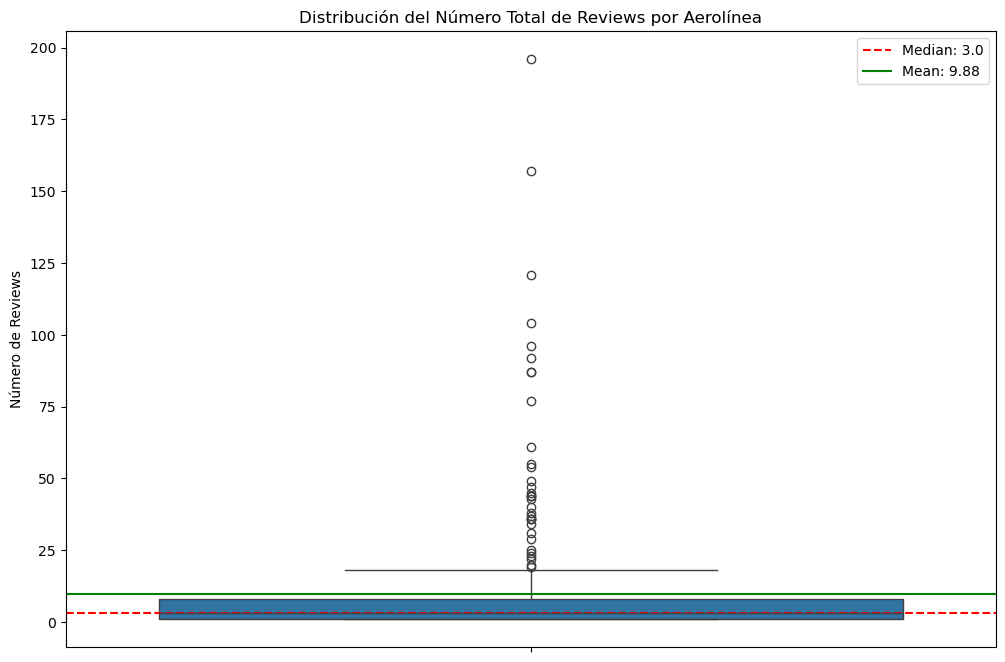

In [216]:


median_value = airlinesBYoverallratingCount['OverallRating'].median()
mean_value = airlinesBYoverallratingCount['OverallRating'].mean()

plt.figure(figsize=(12, 8))
sns.boxplot(data=airlinesBYoverallratingCount, y='OverallRating')
plt.axhline(median_value, color='r', linestyle='--', label=f'Median: {median_value}')
plt.axhline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value.__round__(2)}')
plt.title('Distribución del Número Total de Reviews por Aerolínea')
plt.ylabel('Número de Reviews')
plt.legend()
plt.show()

In [217]:
airlinesBYoverallratingCount.describe() 

,OverallRating
count,313.000000
mean,9.875399
std,21.475250
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,196.000000


Se decide descartar las que tengan menos de la media de ratings

In [218]:
airlinesBYoverallratingCount = airlinesBYoverallratingCount[airlinesBYoverallratingCount['OverallRating'] > 3]
df_RatedFlights_airlineBYrating_filtered = df_RatedFlights[df_RatedFlights['Airline'].isin(airlinesBYoverallratingCount.index)]

df_RatedFlights_airlineBYrating_filtered.index = range(df_RatedFlights_airlineBYrating_filtered.shape[0]) #Nuevo dataframe a usar


In [219]:
airlinesFilteredCount =df_RatedFlights_airlineBYrating_filtered['Airline'].unique().size
print(f"Pasamos de ",df_RatedFlights['Airline'].unique().size,"a", airlinesFilteredCount , "aerolineas") 

Pasamos de  313 a 146 aerolineas


### Tops por overall ranking

In [220]:
top25AirlinesByOverallRating = df_RatedFlights_airlineBYrating_filtered.groupby('Airline').agg({'OverallRating':'mean'}).sort_values(by='OverallRating', ascending=False).head(25)


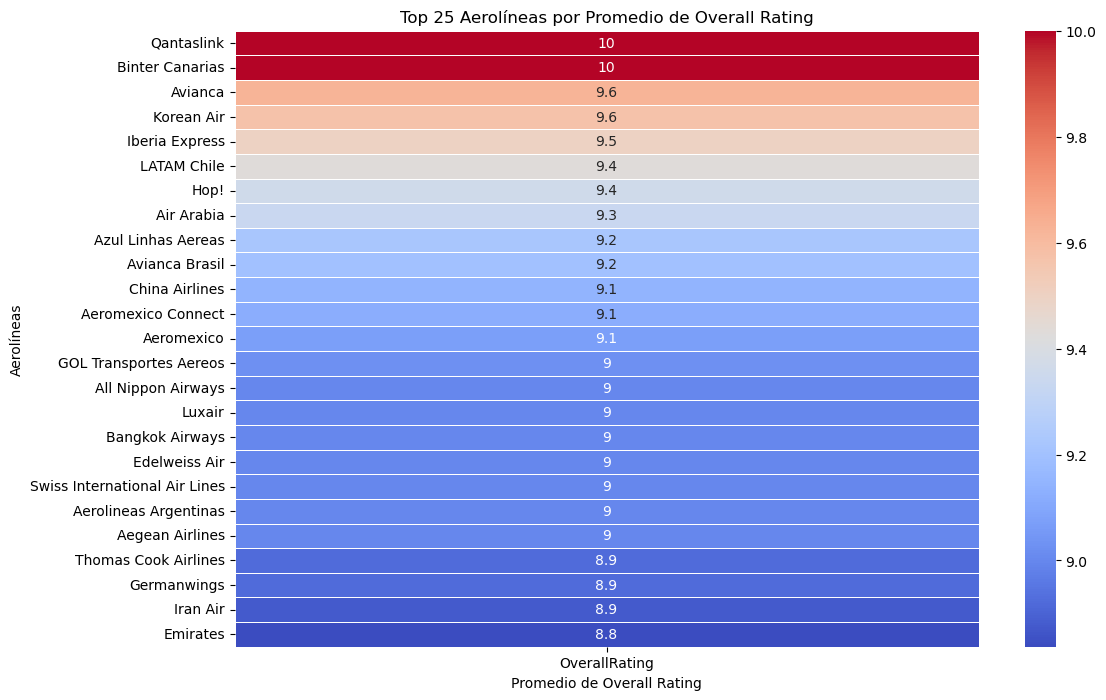

In [221]:
top25AirlinesByOverallRating
# Crear un heatmap para mostrar el top 25 de aerolíneas y sus respectivos promedios de OverallRating
plt.figure(figsize=(12, 8))
sns.heatmap(top25AirlinesByOverallRating[['OverallRating']], annot=True, cmap='coolwarm', cbar=True, linewidths=.5)
plt.title('Top 25 Aerolíneas por Promedio de Overall Rating')
plt.xlabel('Promedio de Overall Rating')
plt.ylabel('Aerolíneas')
plt.show()

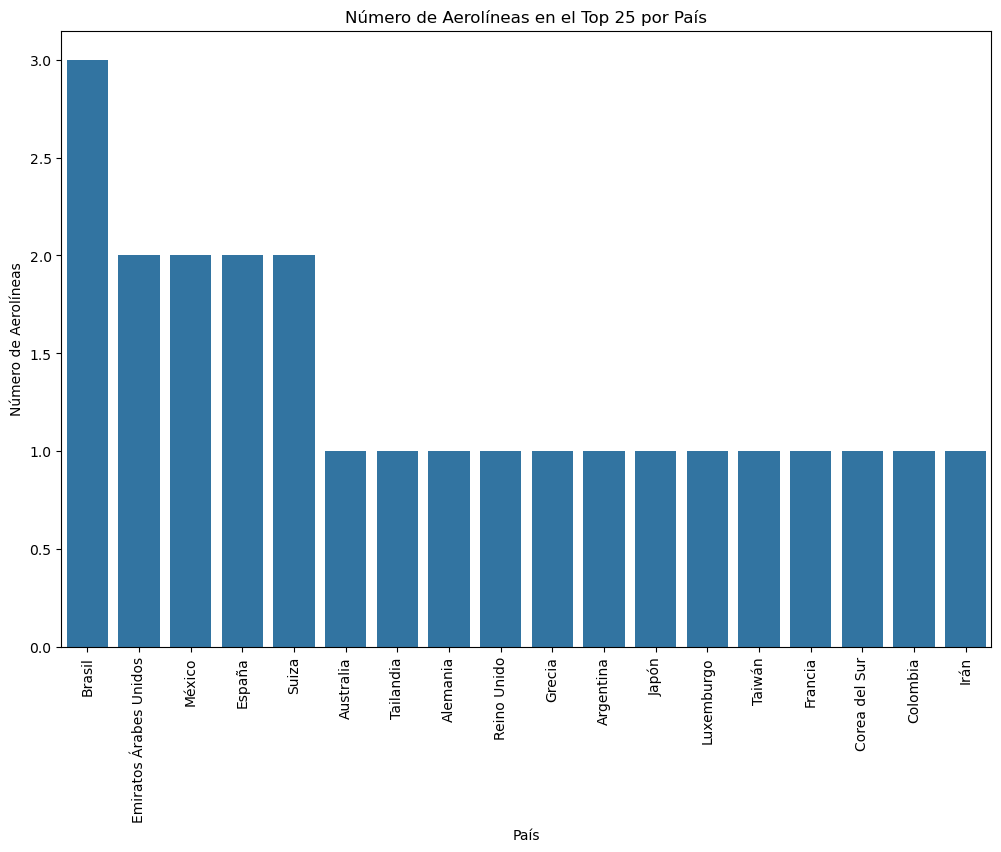

In [222]:
# Obtener los países de las aerolíneas en top25AirlinesByOverallRating
top25AirlinesByOverallRating['Country'] = top25AirlinesByOverallRating.index.map(df_Airlines.set_index('Airline')['Country'])

top25AirlinesByOverallRating
# Calcular el promedio de OverallRating por país
country_avg_rating = top25AirlinesByOverallRating.groupby('Country').agg({'OverallRating': 'mean'}).sort_values(by='OverallRating', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.countplot(data=top25AirlinesByOverallRating, x='Country', order=top25AirlinesByOverallRating['Country'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Número de Aerolíneas en el Top 25 por País')
plt.xlabel('País')
plt.ylabel('Número de Aerolíneas')
plt.grid(False)
plt.show()


## Respuesta a preguntas de alto nivel

In [223]:
df_plane_crashes = pd.read_csv('plane_crashes_with_operator.csv')

# solo trabajaremos con las filas desde el 2000 - 2024

In [224]:
df_flights_all_years = pd.read_csv('flights_all_years.csv')


In [225]:
df_plane_crashes_extended = pd.read_csv('plane_crashes.csv') 

### Primer pregunta

Se trabajará con los datos únicamentes del año 2000-2024

In [226]:


df_plane_crashes['Date']=pd.to_datetime(df_plane_crashes['Date'].str.replace("Date:",""), format="%B %d, %Y")


#Eliminar palabras innecesarias
df_plane_crashes['Location']=df_plane_crashes['Location'].str.replace('Location:','')
df_plane_crashes['Operator']=df_plane_crashes['Operator'].str.replace('Operator:','')
df_plane_crashes['Aboard']=df_plane_crashes['Aboard'].str.replace(r'Aboard:?|\(.*\)','', regex=True)
df_plane_crashes['Fatalities']=df_plane_crashes['Fatalities'].str.replace(r'Fatalities:?|\(.*\)','', regex=True)
df_plane_crashes['Summary']=df_plane_crashes['Summary'].str.replace('Summary:','')


#eliminamos los registros con valores nulos
df_plane_crashes.dropna(inplace=True)

#Se verifica si hay valores duplicados
df_plane_crashes.duplicated().sum()

df_plane_crashes


,Date,Location,Operator,Aboard,Fatalities,Summary
0,2000-01-05,"Abuja, Nigeria",Skypower Express Airways,16,1,During a visual approach the aircraft stalled ...
1,2000-01-10,"Niederhasli, Switzerland",Crossair,10,10,"The aircraft crashed shortly after taking off,..."
2,2000-01-13,"Off Marsa el-Brega, Libya",Avisto,41,22,The aircraft was on a flight from Tripoli to M...
3,2000-01-15,"San Jose, Costa Rica",TACA,20,5,The aircraft was not able to maintain altitude...
4,2000-01-30,"Off Abidjan, Ivory Coast",Kenya Airways,179,169,The aircraft crashed into the Atlantic Ocean t...
...,...,...,...,...,...,...
679,2024-08-31,"Vachkazhets volcano Kamchatka, Russia",Vityaz Aero,22,22,The helicopter crashed after strucking rising ...
680,2024-10-20,"Pohuwato, Indonesia",SAM Air,4,4,While attempting to land at Bumi Panua Pohuwat...
681,2024-11-25,"Vilnius, Lithuania",Swiftair operating for DHL,2,1,The cargo plane was destroyed after it crashed...
682,2024-12-25,"Aktau, Kazakstan",Azerbajan Airlines,67,38,The plane departed Baku for regular service to...


In [227]:
print(f"Hay",df_RatedFlights_airlineBYrating_filtered.shape[0],"Valoraciones repartidas en las", airlinesFilteredCount, "aérolineas")

Hay 2834 Valoraciones repartidas en las 146 aérolineas


In [228]:
print(f"Hay", df_plane_crashes.shape[0],"Accidentes repartidos en las ",df_plane_crashes['Operator'].unique().size, "aerolineas")


Hay 681 Accidentes repartidos en las  603 aerolineas


In [229]:
# Obtenemos el promedio de las calificaciones por aerolínea

airlinesBYoverallratingMean = df_RatedFlights_airlineBYrating_filtered.groupby('Airline').agg({'OverallRating':'mean'}).sort_values(by='OverallRating', ascending=False)
airlinesBYoverallratingMean.reset_index(inplace=True)
airlinesBYoverallratingMean

,Airline,OverallRating
0,Qantaslink,10.000000
1,Binter Canarias,10.000000
2,Avianca,9.625000
3,Korean Air,9.571429
4,Iberia Express,9.500000
...,...,...
141,Norwegian Air Shuttle,5.600000
142,Lufthansa Cityline,5.500000
143,Peach Aviation,5.428571
144,EVA Air,4.250000


In [230]:

#Encontrar las aerolíneas que han tenido accidentes
airlinesWithCrashes = airlinesBYoverallratingMean[airlinesBYoverallratingMean['Airline'].isin(df_plane_crashes['Operator'].unique())]
airlinesWithCrashes

,Airline,OverallRating
12,Aeromexico,9.072727
15,Luxair,9.000000
22,Germanwings,8.923077
23,Iran Air,8.875000
24,Emirates,8.837209
29,Singapore Airlines,8.666667
32,Asiana Airlines,8.625000
35,Air France,8.554140
37,Pegasus Airlines,8.461538
98,American Airlines,7.467532


In [231]:
#Obtenemos ahora el numero de accidentes por aerolinea

airlinesWithCrashes_df_plane_crashes=df_plane_crashes.where(df_plane_crashes['Operator'].isin(airlinesWithCrashes['Airline'])).dropna()

airlinesWithCrashes['Count of Crashes'] = airlinesWithCrashes['Airline'].map(airlinesWithCrashes_df_plane_crashes['Operator'].value_counts())

airlinesWithCrashes_df_plane_crashes['Fatalities'] = airlinesWithCrashes_df_plane_crashes['Fatalities'].astype(int)

fatalitiesCount= airlinesWithCrashes_df_plane_crashes.groupby('Operator').agg({'Fatalities':'sum'})

# fatalitiesCount.reset_index(inplace=True)  
# fatalitiesCount 

airlinesWithCrashes['Count of Fatalities'] = airlinesWithCrashes['Airline'].map(fatalitiesCount['Fatalities'])





C:\Users\davsu\AppData\Local\Temp\ipykernel_50596\1668720832.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airlinesWithCrashes['Count of Crashes'] = airlinesWithCrashes['Airline'].map(airlinesWithCrashes_df_plane_crashes['Operator'].value_counts())
C:\Users\davsu\AppData\Local\Temp\ipykernel_50596\1668720832.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airlinesWithCrashes['Count of Fatalities'] = airlinesWithCrashes['Airline'].map(fatalitiesCount['Fatalities'])


Frecuencia de accidentes por vuelos rateados, se busca mostrar la cantidad de vecs que una aerolinea ha tenido un accidente en relacion a la cantidad de reviews que tiene. El hecho de que las personas se tomen el tiempo de calificar una aerolinea habla de su popularidad y experiencia con el usuario


In [232]:
airlinesWithCrashes['Accident/rated flights']= airlinesWithCrashes['Count of Crashes']/airlinesWithCrashes['Airline'].map(df_RatedFlights_airlineBYrating_filtered.groupby('Airline').agg({'OverallRating':'count'}).sort_values(by='OverallRating', ascending=False)['OverallRating'])

#estandarizar la columna Accident/rated flights
airlinesWithCrashes['Accident/rated flights'] = (airlinesWithCrashes['Accident/rated flights'] - airlinesWithCrashes['Accident/rated flights'].mean()) / airlinesWithCrashes['Accident/rated flights'].std()


C:\Users\davsu\AppData\Local\Temp\ipykernel_50596\1257216495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airlinesWithCrashes['Accident/rated flights']= airlinesWithCrashes['Count of Crashes']/airlinesWithCrashes['Airline'].map(df_RatedFlights_airlineBYrating_filtered.groupby('Airline').agg({'OverallRating':'count'}).sort_values(by='OverallRating', ascending=False)['OverallRating'])
C:\Users\davsu\AppData\Local\Temp\ipykernel_50596\1257216495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airlin

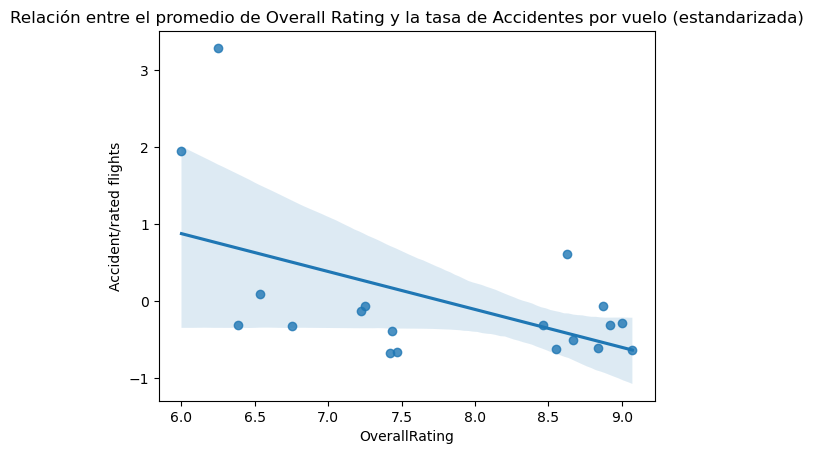

In [233]:
grafica1=sns.regplot(data=airlinesWithCrashes, x='OverallRating', y='Accident/rated flights', fit_reg=True)
grafica1.title.set_text('Relación entre el promedio de Overall Rating y la tasa de Accidentes por vuelo (estandarizada)')

Se resoponde a la primera pregunta: ¿Hay alguna correlación entre el rating que recibe una aerolínea para ciertos viajes en ciertas fechas y un accidente aéreo propio de la aerolínea?

In [234]:
# Calcular la correlación de Pearson
pearson_corr, p_value_pearson = stats.pearsonr(airlinesWithCrashes["OverallRating"], airlinesWithCrashes["Accident/rated flights"])

# Función para calcular el intervalo de confianza
def confidence_interval(r, n, confidence=0.95):
    stderr = 1.0 / np.sqrt(n - 3)
    delta = stats.norm.ppf((1 + confidence) / 2) * stderr
    lower = np.tanh(np.arctanh(r) - delta)
    upper = np.tanh(np.arctanh(r) + delta)
    return lower, upper

n = airlinesWithCrashes.shape[0]  # Cantidad de aerolíneas en la muestra
ci_lower, ci_upper = confidence_interval(pearson_corr, n)

# Imprimir resultados con explicaciones
print(f"Existe una correlación de {pearson_corr:.3f} entre el promedio de Overall Rating y la tasa de Accidentes por vuelo (estandarizada).")
print(f"Cantidad de aerolíneas que se pudieron usar: {n}")
print("Periodo de años: 2000-2024")

print(f"Valor de correlación de Pearson: {pearson_corr:.3f}, con un valor p de: {p_value_pearson:.5f}")
if p_value_pearson < 0.05:
    print("La correlación es estadísticamente significativa (p < 0.05), lo que indica que hay evidencia suficiente para afirmar que existe una relación entre el Overall Rating y la tasa de Accidentes por vuelo.")
else:
    print("La correlación no es estadísticamente significativa (p >= 0.05), lo que indica que no hay evidencia suficiente para afirmar que existe una relación entre el Overall Rating y la tasa de Accidentes por vuelo.")

print(f"Intervalo de confianza (95%): ({ci_lower:.3f}, {ci_upper:.3f})")



Existe una correlación de -0.524 entre el promedio de Overall Rating y la tasa de Accidentes por vuelo (estandarizada).
Cantidad de aerolíneas que se pudieron usar: 19
Periodo de años: 2000-2024
Valor de correlación de Pearson: -0.524, con un valor p de: 0.02137
La correlación es estadísticamente significativa (p < 0.05), lo que indica que hay evidencia suficiente para afirmar que existe una relación entre el Overall Rating y la tasa de Accidentes por vuelo.
Intervalo de confianza (95%): (-0.790, -0.091)


En este análisis, se ha examinado la relación entre el promedio de Overall Rating de las aerolíneas y la tasa de accidentes por vuelo. Se encontró una correlación negativa moderada (-0.524) entre estas dos variables, lo que sugiere que las aerolíneas con mejores calificaciones tienden a tener una menor tasa de accidentes por vuelo. Esta correlación es estadísticamente significativa con un valor p de 0.021, lo que indica que hay evidencia suficiente para afirmar que existe una relación entre el Overall Rating y la tasa de Accidentes por vuelo. Sin embargo, es importante considerar otros factores que pueden influir en la seguridad de las aerolíneas y no basarse únicamente en las calificaciones de los usuarios.

In [235]:
df_flights_all_years

,Year,Date,Flights
0,2025 Number of flights,2024-12-31,156956
1,2025 Number of flights,2025-01-01,205823
2,2025 Number of flights,2025-01-02,213193
3,2025 Number of flights,2025-01-03,198500
4,2025 Number of flights,2025-01-04,186594
...,...,...,...
2951,2021 7-day moving average,2025-12-26,155327
2952,2021 7-day moving average,2025-12-27,150982
2953,2021 7-day moving average,2025-12-28,145823
2954,2021 7-day moving average,2025-12-29,141828


### Segunda pregunta

In [236]:
df_plane_crashes_extended['Date']=pd.to_datetime(df_plane_crashes_extended['Date'].str.replace("Date:",""), format="%B %d, %Y")


#Eliminar palabras innecesarias
df_plane_crashes_extended['Location']=df_plane_crashes_extended['Location'].str.replace('Location:','')
df_plane_crashes_extended['Aboard']=df_plane_crashes_extended['Aboard'].str.replace(r'Aboard:?|\(.*\)','', regex=True)
df_plane_crashes_extended['Fatalities']=df_plane_crashes_extended['Fatalities'].str.replace(r'Fatalities:?|\(.*\)','', regex=True)
df_plane_crashes_extended['Summary']=df_plane_crashes_extended['Summary'].str.replace('Summary:','')


#eliminamos los registros con valores nulos
df_plane_crashes_extended.dropna(inplace=True)

#Se verifica si hay valores duplicados
df_plane_crashes_extended.duplicated().sum()

#eliminar accidentes del año 2025

df_plane_crashes_extended = df_plane_crashes_extended[df_plane_crashes_extended['Date'].dt.year < 2025]


df_plane_crashes_extended

,Date,Location,Aboard,Fatalities,Summary
0,1908-09-17,"Fort Myer, Virginia",2,1,"During a demonstration flight, a U.S. Army fly..."
1,1909-09-07,"Juvisy-sur-Orge, France",1,1,Eugene Lefebvre was the first pilot to ever be...
2,1908-09-17,"Fort Myer, Virginia",2,1,"During a demonstration flight, a U.S. Army fly..."
3,1909-09-07,"Juvisy-sur-Orge, France",1,1,Eugene Lefebvre was the first pilot to ever be...
4,1912-07-12,"Atlantic City, New Jersey",5,5,First U.S. dirigible Akron exploded just offsh...
...,...,...,...,...,...
4959,2024-08-31,"Vachkazhets volcano Kamchatka, Russia",22,22,The helicopter crashed after strucking rising ...
4960,2024-10-20,"Pohuwato, Indonesia",4,4,While attempting to land at Bumi Panua Pohuwat...
4961,2024-11-25,"Vilnius, Lithuania",2,1,The cargo plane was destroyed after it crashed...
4962,2024-12-25,"Aktau, Kazakstan",67,38,The plane departed Baku for regular service to...


Dataset con accidentes de los siglos XX y XXI

C:\Users\davsu\AppData\Local\Temp\ipykernel_50596\3876916949.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_crashes.index, y=monthly_crashes.values, palette='viridis')


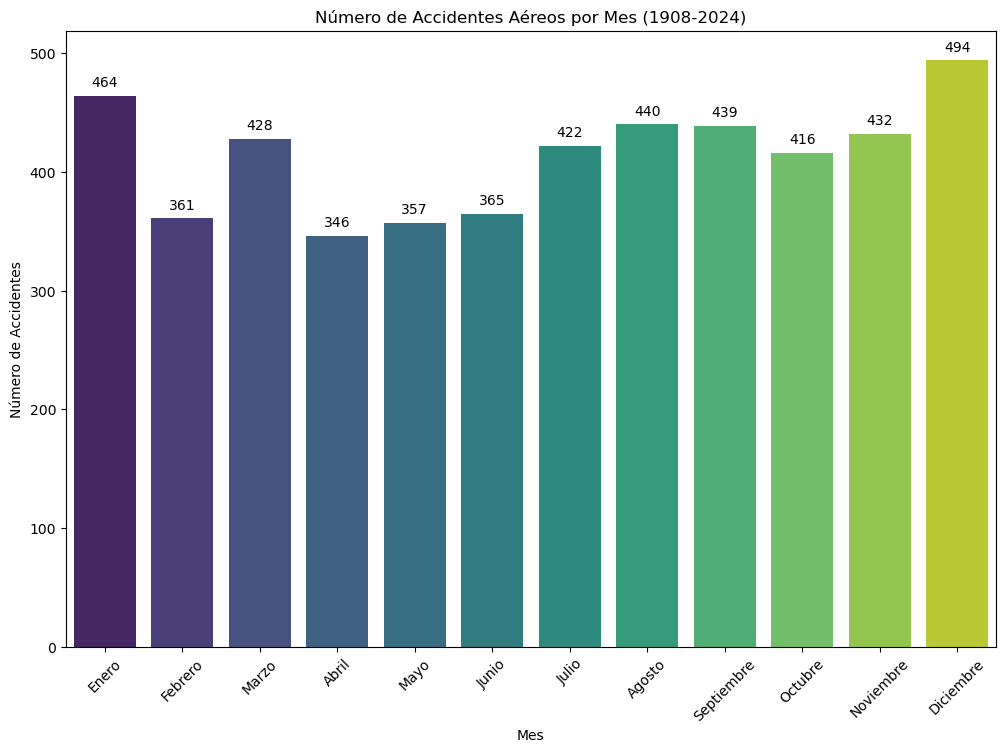

In [237]:
# Patrones estacionales en la ocurrencia de accidentes aéreos por mes

df_plane_crashes_extended['Month'] = df_plane_crashes_extended['Date'].dt.month
monthly_crashes = df_plane_crashes_extended.groupby('Month').size()

# Crear el gráfico de barras con seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=monthly_crashes.index, y=monthly_crashes.values, palette='viridis')

# Nombres de los meses en español
month_names = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xticks(ticks=range(12), labels=month_names, rotation=45)

# Escribir el número de accidentes en cada barra
for i, value in enumerate(monthly_crashes.values):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.title('Número de Accidentes Aéreos por Mes (1908-2024)')
plt.xlabel('Mes')
plt.ylabel('Número de Accidentes')
plt.grid(False)
plt.show()


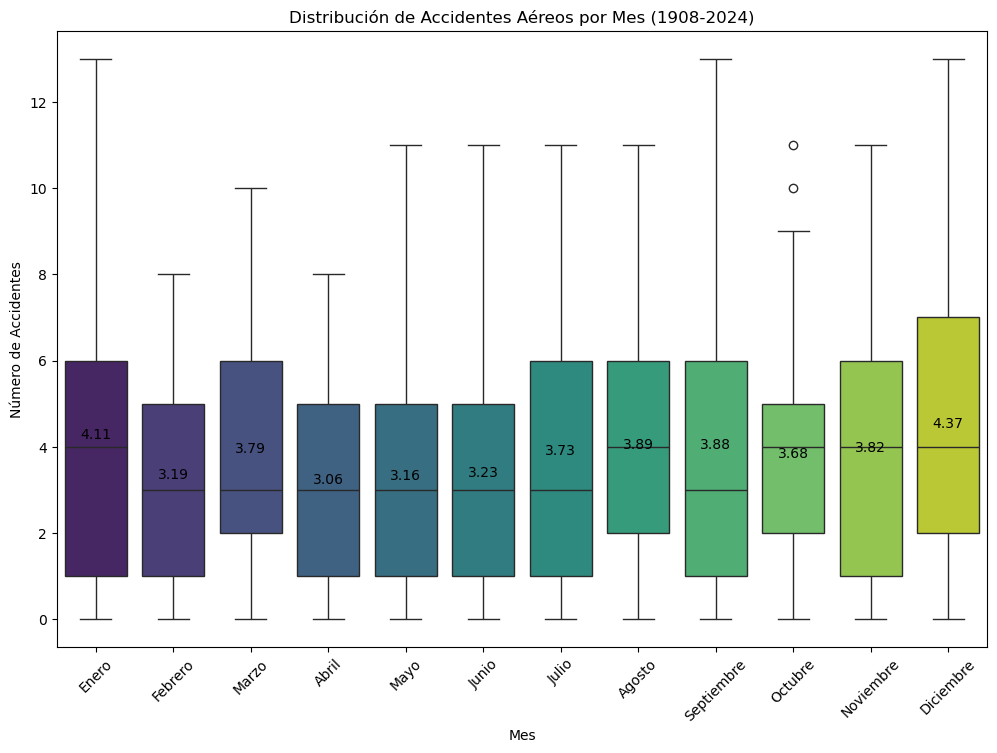

In [238]:
#Distribución De Accidentes Aéreos Por Mes (1908-2024) con un grafico de boxplots por cada mes
df_plane_crashes_extended['Year'] = df_plane_crashes_extended['Date'].dt.year   

numeroDeAccidentespormesYanio = df_plane_crashes_extended.groupby(['Month','Year']).agg({'Date':'count'}).unstack().T

numeroDeAccidentespormesYanio
numeroDeAccidentespormesYanio.fillna(0, inplace=True)

# Crear el gráfico de boxplots
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=numeroDeAccidentespormesporanio, palette='viridis')
# plt.title('Distribución de Accidentes Aéreos por Mes (1908-2024)')
# plt.xlabel('Mes')
# plt.ylabel('Número de Accidentes')
# plt.grid(False)
# plt.show()

numeroDeAccidentespormesYanio.reset_index(inplace=True)

#eliminar columna de anios y 'Date'
numeroDeAccidentespormesYanio.drop(columns=['Year', 'level_0'], inplace=True)
numeroDeAccidentespormesYanio


# Crear el gráfico de boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=numeroDeAccidentespormesYanio, palette='viridis')
plt.title('Distribución de Accidentes Aéreos por Mes (1908-2024)')
plt.xlabel('Mes')
plt.ylabel('Número de Accidentes')
plt.xticks(ticks=range(12), labels=month_names, rotation=45)

# Calcular y escribir el promedio en cada boxplot
means = numeroDeAccidentespormesYanio.mean()
for i, mean in enumerate(means):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')

plt.grid(False)
plt.show()



Se resoponde a la segunda pregunta: ¿Existen patrones estacionales en la ocurrencia de accidentes aéreos? 

### Tercera pregunta

Provocado: Un accidente atribuible a errores humanos (pilotos, controladores, etc.), fallos técnicos, actos intencionales (sabotajes) o negligencia.

Azar: Accidente debido a factores impredecibles, como condiciones climáticas extremas u otras causas no controlables.

Se hará uso de la IA para que esta se encargue de analizar parte del summary y así determine si el accidene fue o no provocado

In [271]:
df_generated= pd.read_csv('plane_crashes_AIgenerated.csv')

df_generated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, September 17 to February 17
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        34 non-null     int64 
 1   Year        34 non-null     object
 2   Location    34 non-null     object
 3   Aboard      34 non-null     object
 4   Fatalities  34 non-null     object
 5   Summary     34 non-null     object
 6   Cause       34 non-null     object
dtypes: int64(1), object(6)
memory usage: 2.1+ KB


Se genera un dataset de 34 accidentes en donde la IA ha analizado si el accidente fue provocado o producto del azar

C:\Users\davsu\AppData\Local\Temp\ipykernel_50596\453189635.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_generated, x='Cause', palette='viridis')


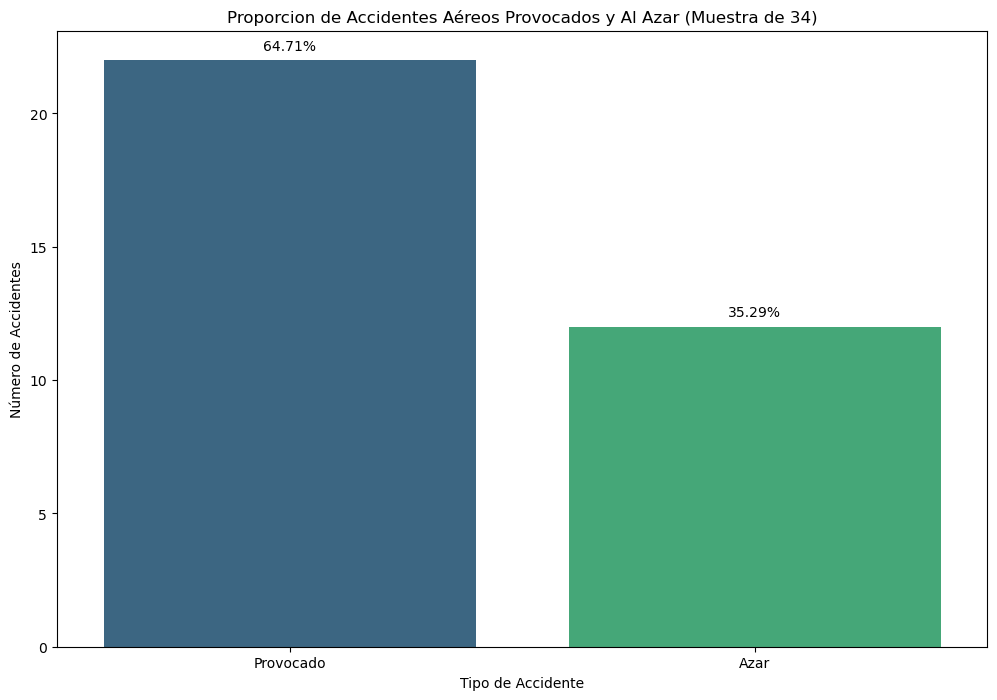

In [275]:
#has un grafico de barras de los que fueron provocados o al azar 
df_generated['Cause'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df_generated, x='Cause', palette='viridis')
plt.title('Proporcion de Accidentes Aéreos Provocados y Al Azar (Muestra de 34)')
plt.xlabel('Tipo de Accidente')
plt.ylabel('Número de Accidentes')
plt.grid(False)

# Calcular el porcentaje y escribirlo en cada barra
total = len(df_generated)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [274]:
# Prueba de hipótesis para la proporción de accidentes provocados y al azar
# H0: La proporción de accidentes provocados y al azar es la misma
# H1: La proporción de accidentes provocados y al azar no es la misma

# Conteo de accidentes provocados y al azar
provoked_count = df_generated['Cause'].value_counts()['Provocado']
random_count = df_generated['Cause'].value_counts()['Azar']

# Conteo total de accidentes
total_accidents = df_generated.shape[0]

# Proporciones
provoked_proportion = provoked_count / total_accidents
random_proportion = random_count / total_accidents

# Proporción esperada bajo la hipótesis nula
expected_proportion = 0.5

# Estadístico de prueba
z_score = (provoked_proportion - expected_proportion) / np.sqrt(expected_proportion * (1 - expected_proportion) / total_accidents)

# Valor p
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))

# Imprimir resultados con explicaciones

print(f"Proporción de accidentes provocados: {provoked_proportion:.3f}")
print(f"Proporción de accidentes al azar: {random_proportion:.3f}")
print(f"Total de accidentes: {total_accidents}")
print(f"Proporción esperada bajo la hipótesis nula: {expected_proportion}")
print(f"Estadístico de prueba (Z): {z_score:.3f}")
print(f"Valor p: {p_value:.5f}")

if p_value < 0.05:
    print("La proporción de accidentes provocados y al azar no es la misma (p < 0.05), por lo que rechazamos la hipótesis nula.")
else:
    print("La proporción de accidentes provocados y al azar es la misma (p >= 0.05), por lo que no rechazamos la hipótesis nula.")

Proporción de accidentes provocados: 0.647
Proporción de accidentes al azar: 0.353
Total de accidentes: 34
Proporción esperada bajo la hipótesis nula: 0.5
Estadístico de prueba (Z): 1.715
Valor p: 0.08635
La proporción de accidentes provocados y al azar es la misma (p >= 0.05), por lo que no rechazamos la hipótesis nula.
